## XGBoost 

- XGBoost (eXtreme Gradient Boost) is an enhanced form of the gradient boosting machine learning model that combines weaker models (usuaully decision trees) together and subsequently trained in succesion with each iteration focusing on correcting the errors of the previous. 

- Unlike regular gradient boosting, XGBoost integrates L1 and L2 regularization and more sophisticated tree pruning (over and underfitting prevention) as well as parallel processing making this model perform well with larger datasets (highly scalable).

In [ ]:
## All the libraries for XGBoost:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Splitting training and test data
from sklearn.model_selection import train_test_split

#For creating training pipeline and XGboost classification tasks
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

#Tuning model using BayesSearchCV and passing optimizer range of values to try
from skopt import BayesSearchCV
from skopt.space import Real, Integer

#Specific XGBoost plots
from skopt.plots import plot_convergence
from xgboost import plot_importance

#ROC Multiclass plot
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

#Pip installs:
#XGboost
#skopt

df = pd.read_csv("Student_performance_scaled.csv")

df.head()

,Age,Gender,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GradeClass
0,0.472919,0.978492,0.253711,1.780336,-0.890822,1.522371,-0.108744,-0.788476,-0.660132,2.019544,-0.431866,2.0
1,1.362944,-1.021981,-0.746087,0.997376,-1.717694,-0.656870,-0.999551,-0.788476,-0.660132,-0.495161,-0.431866,1.0
2,-1.307132,-1.021981,1.253509,-0.984045,1.353542,-0.656870,-0.108744,-0.788476,-0.660132,-0.495161,-0.431866,4.0
3,0.472919,0.978492,1.253509,0.045445,-0.063951,-0.656870,0.782063,1.268269,-0.660132,-0.495161,-0.431866,3.0
4,0.472919,0.978492,0.253711,-0.902311,0.290422,1.522371,0.782063,-0.788476,-0.660132,-0.495161,-0.431866,4.0


## Splitting Training and Test Data

In [24]:
#Seperate features from target
x= df.drop(columns='GradeClass')
y= df['GradeClass']

#Split x and y into training and test. 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify= y, random_state= 8)

## Training Pipeline

- Pipelines streamline the preprocessing, model training, and evaluation.

In [25]:
#Create list of steps for pipline, setting random state ensures same results each run
estimators = [('clf', XGBClassifier(random_state=8))]

#Build pipeline from modeling steps (data preprocessing already done)
pipe = Pipeline(steps=estimators)

#Show built pipeline
pipe

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

## Hyperparameter Tuning

- These are a set of parameters that help fine tune and optimize the XGBoost model.

- Providing a range for each hyperparameter, BayesSearch can be utilised to find the optimal values for each of the hyperparameters.

In [26]:
#Search space used for defining hyperparams and setting ranges for optimization 
search_space = {
    'clf__learning_rate' : Real(0.01, 0.3, prior='log-uniform'),
    'clf__max_depth' : Integer(2, 120),
    'clf__min_child_weight': Integer(1, 20),
    'clf__gamma' : Real(0, 5),
    'clf__subsample' : Real(0.5, 1),
    'clf__colsample_bytree' : Real(0.5, 1)
}

#Using BayesSearchCV to optimize hyperparams in set ranges
opt =  BayesSearchCV(pipe, search_space, cv= 5, n_iter= 30, scoring= 'roc_auc_ovr', random_state=8)

## XGBoost Model Training

In [27]:
#Trains model and finds optimized hyperparams
opt.fit(x_train, y_train)

#Shows optimized hyperparams
clf_params = opt.best_params_
clf_params

OrderedDict([('clf__colsample_bytree', 1.0),
             ('clf__gamma', 1.168291298946482),
             ('clf__learning_rate', 0.17429148910524114),
             ('clf__max_depth', 95),
             ('clf__min_child_weight', 15),
             ('clf__subsample', 0.7340484670123454)])

## Evaluate Model for Predictions

- The training and test scores (based on roc_auc_ovr metrics) are promising as both are close to the value of 1 and are close to each other.

- The convergence plot shows gradual improvement through each evaluation until a stable solution was found (plateau).


In [28]:
#Shows the pipeline instance with best hyperparam combinations
opt.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=1.0, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=1.168291298946482, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.17429148910524114, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=95,
                               max_leaves=None, min_child_weight=15,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [29]:
#Shows best CV (cross-validation) score from roc_auc_ovr during training
opt.best_score_

np.float64(0.8652953895649971)

In [30]:
#Shows final models score on test data
opt.score(x_test, y_test)

np.float64(0.900316781235748)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

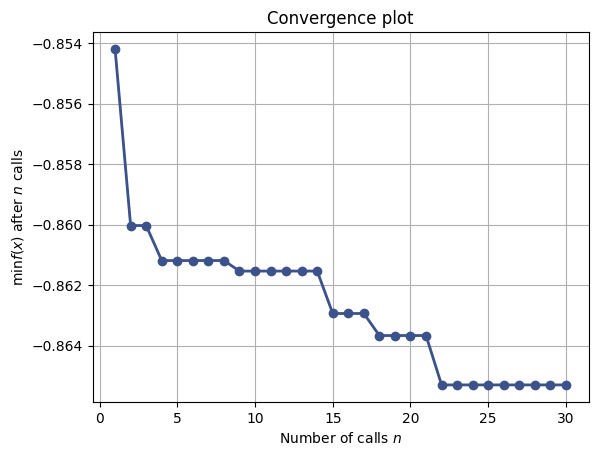

In [ ]:
#Covergence plot based on BayesSearch optimum results
plot_convergence(opt.optimizer_results_) 

## Measuring Feature Performance

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

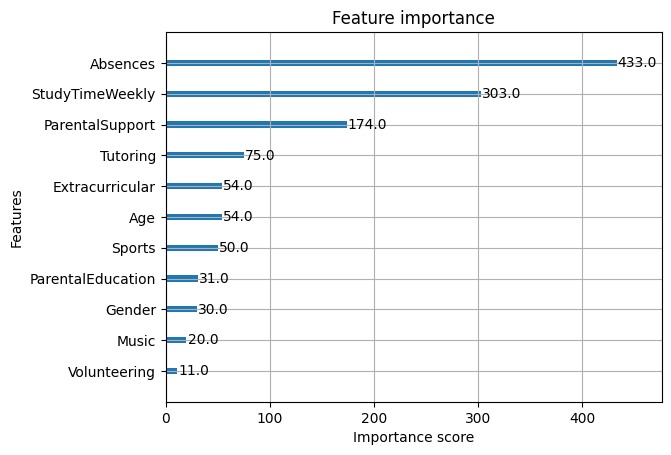

In [32]:
#Get the optimal pipeline steps (tuples)
xgboost_step = opt.best_estimator_.steps[0]

#Get trained model from tuple
xgboost_model = xgboost_step[1]

#Visualize feature performance (contribution to predictions)
plot_importance(xgboost_model)

## ROC Curves

- A good model is represented by values in the top left portion (True Positive Rate (TPR)) with each AUC (Area Under Curve) being close to 1.0.

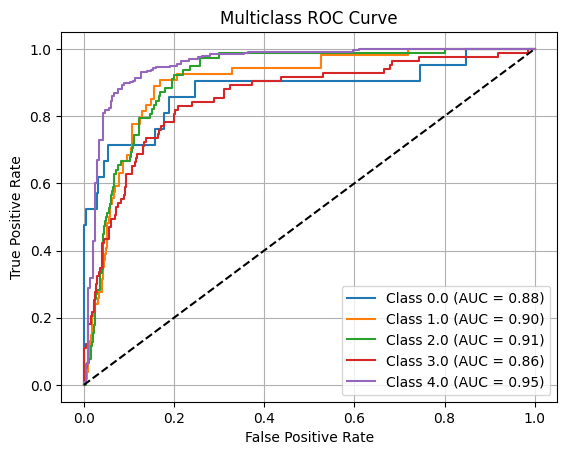

In [ ]:
# Binarize your y labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = opt.predict_proba(x_test)

# Plot ROC curve for each class
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()